## **3. 평균 이동**

### **평균 이동(Mean Shift)의 개요**

- 평균 이동은 K-평균과 유사하게 중심을 군집의 중심으로 지속적으로 움직이면서 군집화 수행
- BUT K-평균이 중심에 소속된 데이터의 평균 거리 중심으로 이동하는 데 반해
- 평균 이동은 중심을 데이터가 모여 있는 밀도가 가장 높은ㅇ 곳으로 이동시킴

- 평균 이동 군집화는 데이터의 분포도를 이용해 군집 중심점을 찾음
- 이를 위해 확률 밀도 함수 pdf 사용
- 군집 종심점: 가장 집중적으로 데이터가 모여 있어 확률 밀도 함수가 피크인 점
- 일반적으로 주어진 모델의 확률 밀도 함수를 찾기 위해서 KDE (Kernel Density Estimation) 이용 

- 평균 이동 군집화는 특정 데이터를 반경 내의 데이터 분포 확률 밀도가 가장 높은 곳으로 이동하기 위해
- 주변 데이터와의 거리값을 KDE 함수값으로 입력한 뒤
- 그 반환값을 현재 위치에서 업데이트하면서 이동하는 방식을 취함
- 이러한 방식을 전체 데이터에 반복적으로 적용하면서 데이터의 군집 중심점을 찾아냄

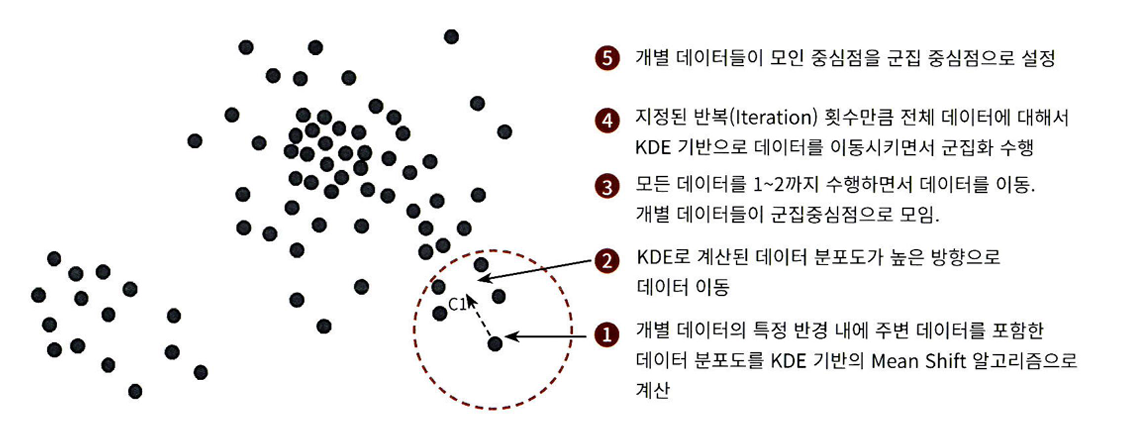

KDE(Kernel Density Estimation)
- 커널(Kernel) 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적인 방법
- 개별 관측 데이터에 커널 함수를 적용한 뒤, 이 적용값을 모두 더한 후, 개별 관측 데이터의 건수로 나눠 확률밀도함수 추정
- 대표적인 커널 함수: 가우시안 분포 함수
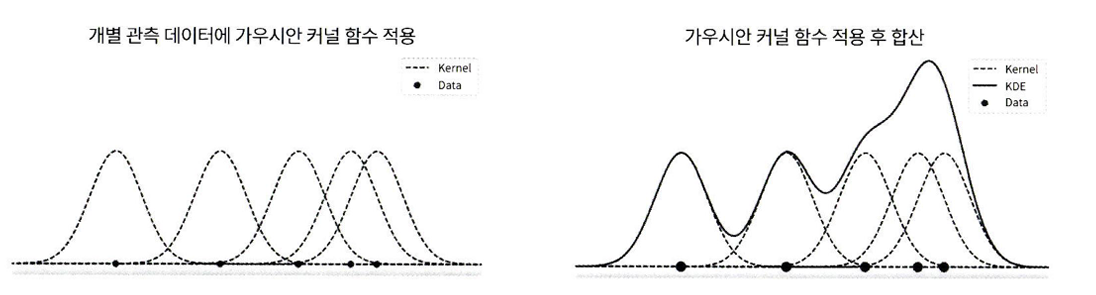
- 커널 함수 식 (K: 커널 함수, x: 확률 변숫값, xi: 관측값, h: 대역폭)
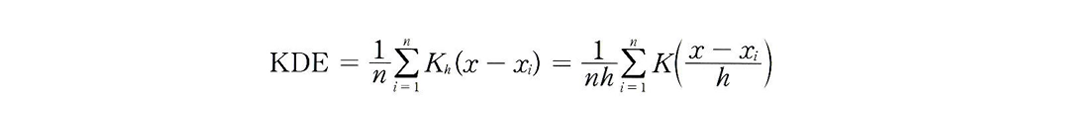
- 대역폭 h: KDE 형태를 부드러운 (또는 뾰족한) 형태로 평활화(smoothing)하는 데 적용되며, h를 어떻게 설정하느냐에 따라 확률 밀도 추정 성능을 크게 좌우 가능
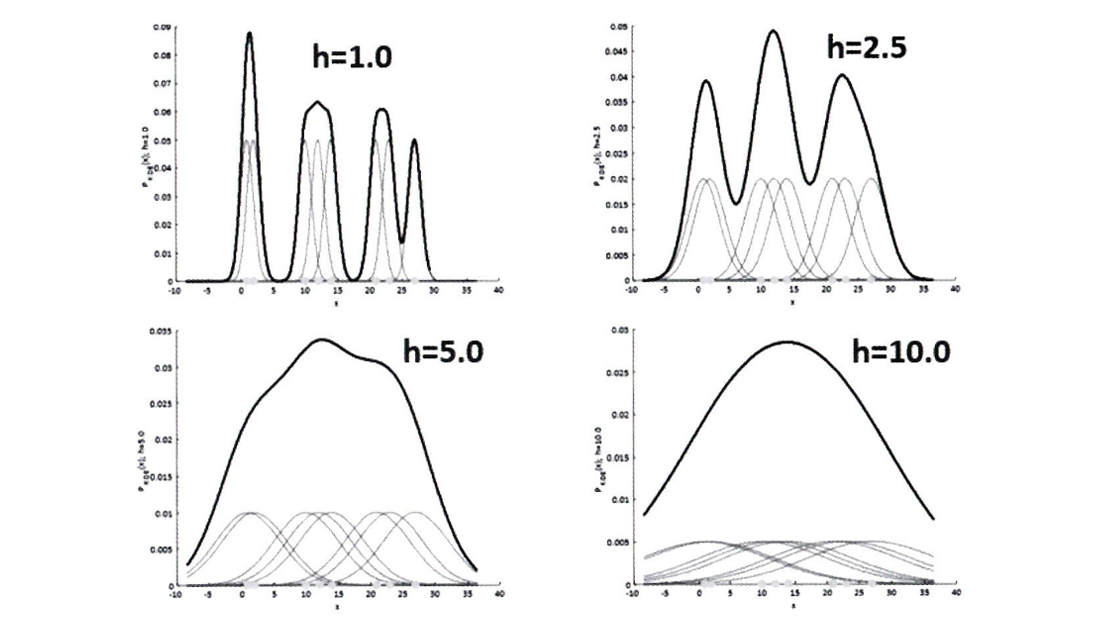
- 일반적으로 평균 이동 군집화는 대역폭이 클수록 평활화된 KDE로 인해 적은 수의 군집 중심점을 가지며, 대역폭이 작을수록 많은 수의 군집 중심점을 가짐
- 평균 이동 군집화는 군집의 개수를 지정하지 않으며, 오직 대역폭의 크기에 따라 군집화 수행
- 사이킷런은 평균 이동 군집화를 위해 MeanShift 클래스 제공
  - 가장 중요한 초기화 파라미터: bandwidth (= KDE의 대역폭 h)
  - 대역폭 크기 설정이 군집화의 품질에 큰 영향을 미치기 때문에 사이킷런은 최적의 대역폭 계산을 위해 estimate_bandwidth() 함수 제공

In [1]:
# make_blobs()의 cluster_std를 0.7로 정한 3개 군집의 데이터에 대해 bandwidth를 0.8로 설정한 평균 이동 군집화 알고리즘 적용
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


- 군집이 0부터 5까지6개로 지나치게 세분화되어 군집화됨
- 일반적으로 bandwidth를 작게 할수록 군집 개수가 많아지므로 이번에는 bandwidth=1로 하여 MeanShift 수행해보자

In [3]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


- 3개의 군집으로 군집화됨
- 데이터의 분포 유형에 따라 bandwidth값의 변화는 군집화 개수에 큰 영향을 미칠 수 있음  
  => MeanShift에서는 bandwidth를 최적화 값으로 설정하는 것이 중요  
  => estimate_bandwidth() 함수 이용

In [4]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


- 구한 bandwidth 값 이용해 다시 군집화 수행

In [5]:
import pandas as pd 

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y 

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


- 3개의 군집으로 구성됨
- 해당 3개 군집을 시각화해보자
- 평균 이동도 K-평균과 유사하게 중심을 가지고 있으므로 cluster_centers_ 속성으로 군집 중심 좌표 표시 가능

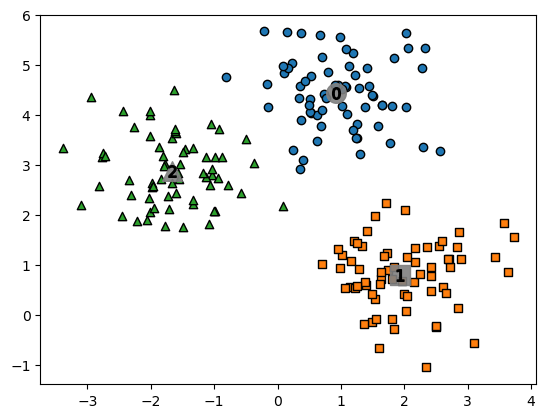

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label'] == label]
    center_x_y = centers[label]
    
    # 군집별로 다른 마커로 산점도 적용 
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [7]:
# target값과 군집 label값 비교
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


- target 값과 군집 label 값이 1:1로 잘 매칭됨

평균 이동의 장점
- 데이터 세트의 형태를 특정 형태로 가정한다든가, 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화 가능
- 이상치의 영향력이 크지 않음
- 미리 군집의 개수를 정할 필요 없음

평균 이동의 단점
- 알고리즘의 수행 시간이 오래 걸림
- bandwidth의 크기에 따른 군집화 영향도가 매우 큼

## **4. GMM(Gaussian Mixture Model)**

### **GMM(Gaussian Mixture Model) 소개**

- GMM 군집화: 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식
- 가우시안 분포 (정규 분포): 좌우 대칭형의 종 형태를 가진 연속 확률 함수
- GMM에서는 여러 개의 가우시안 분포가 섞인 데이터 분포에서 개별 유형의 가우시안 분포를 추출하여 모수 추정
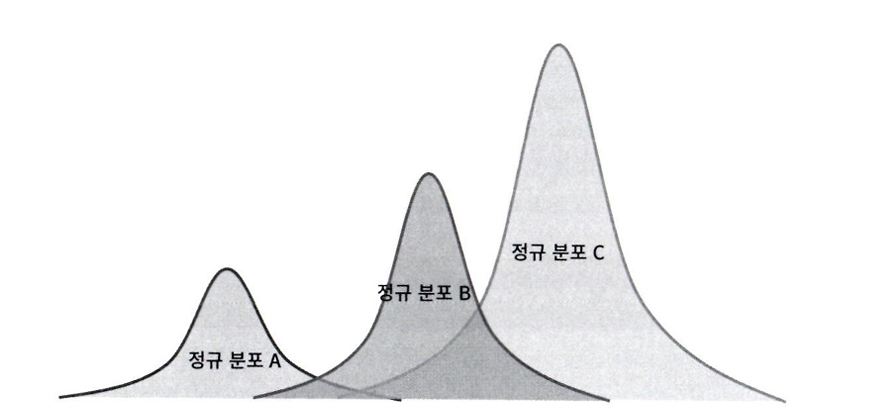
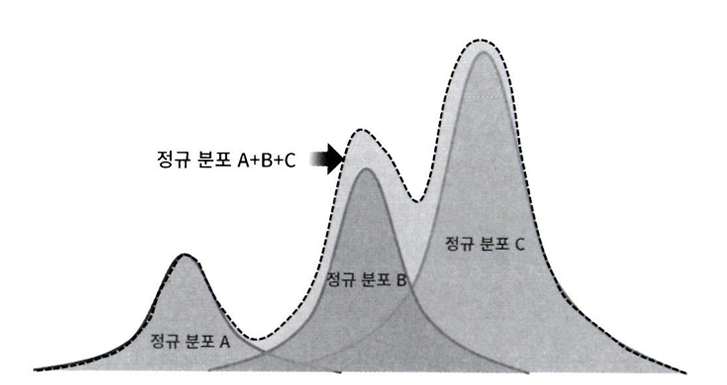
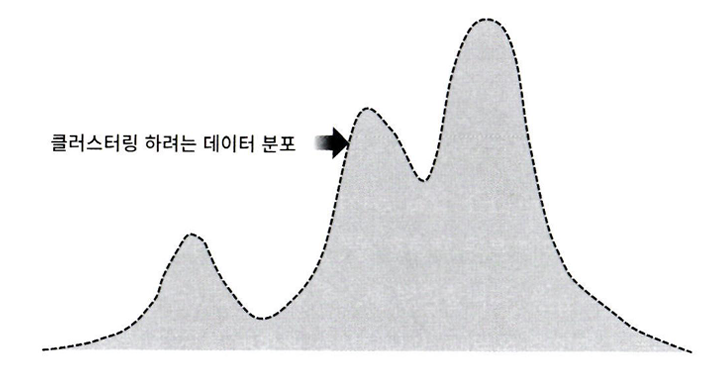
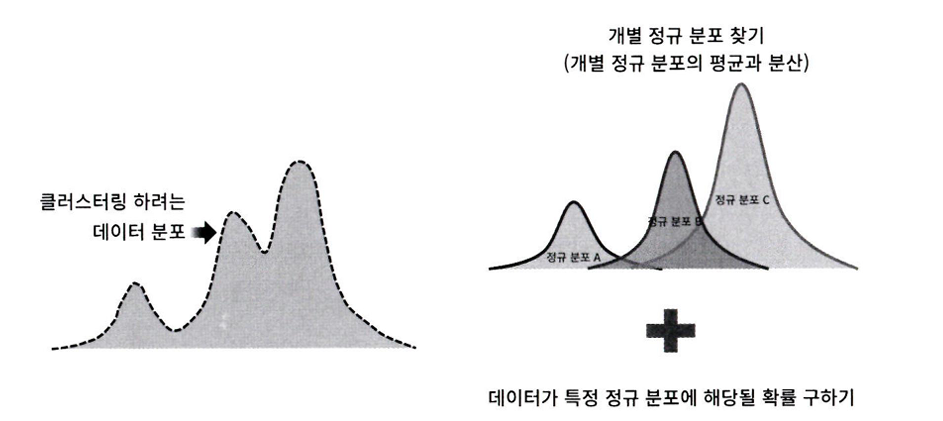
- 모수 추정의 대표적인 2가지 목적
  1. 개별 정규 분포의 평균과 분산 추정
  2. 각 데이터가 어떤 정규 분포에 해당되는지의 확률 추정
- 이러한 모수 추정을 위헤 GMM은 EM(Expectation and Maximization) 방법 적용
- 사이킷런은 이러한 GMM의 EM 방식을 통한 모수 추정 군집화를 지원하기 위해 GaussianMixture 클래스 지원

### **GMM을 이용한 붓꽃 데이터 세트 군집화**

- **GMM**은 **확률** 기반 군집화 vs. **K-평균**은 **거리** 기반 군집화
- 이번에는 붓꽃 데이터 세트로 이 두 가지 방식을 이용해 군집화를 수행한 뒤 두 방식을 비교해보자

In [8]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris=load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns = feature_names)
irisDF['target'] = iris.target

- GaussianMatrix 객체의 가장 중요한 초기화 파라미터는 n_components
- n_components: gaussian mixture의 모델의 총 개수 (K-평균의 n_clusters와 같이 군집의 개수를 정하는 데 중요한 역할 수행)

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼 명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target 

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: count, dtype: int64


C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- 앞 절의 붓꽃 데이터 세트의 K-평균 군집화 결과보다 더 효과적인 분류 결과가 도출됨

In [10]:
# 붓꽃 데이터 세트의 K-평균 군집화
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: count, dtype: int64


- 둘 중 어떤 알고리즘이 더 뛰어난 것이 아니라
- 붓꽃 데이터 세트가 GMM 군집화에 더 효과적이라는 의미
- **K-평균**은 평균 거리 중심으로 중심을 이동하면서 군집화를 수행하므로 **개별 군집 내의 데이터가 원형으로 흩어져 있는 경우**에 매우 효과적인 군집화 수행 가능

### **GMM과 K-평균의 비교**

**K-Means**
- K-Means는 개별 군집의 중심에서 원형의 범위로 군집화 수행  
  => 데이터 세트가 원형의 범위를 가질수록 KMeans의 군집화 효율은 더욱 높아짐
- make_blobs()의 군집 수를 3개로 하되, cluster_std를 0.5로 설정해 군집 내의 데이터를 뭉치게 유도한 데이터 세트에 KMeans 적용
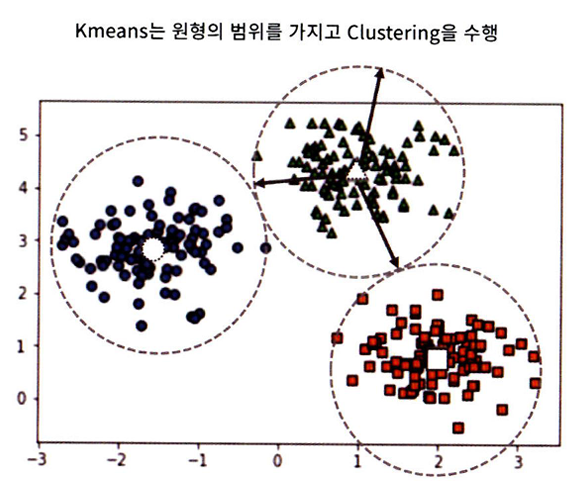
- 이렇게 cluster_std를 작게 설정하면 데이터가 원형 형태로 분산될 수 있음
- K-Means는 데이터가 원형의 범위로 퍼져 있지 않은 경우 군집화를 잘 수행하지 못함

In [13]:
# 군집을 시각화하기 위한 함수: visualize_cluster_plot()
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

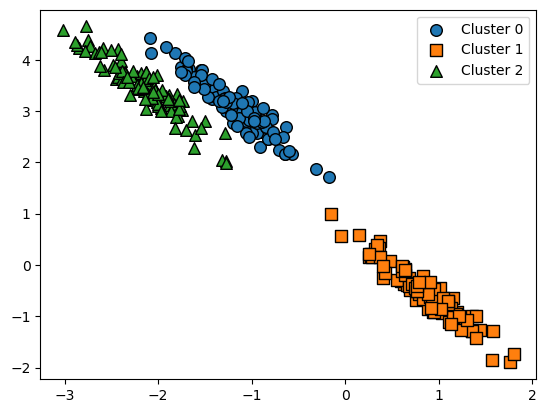

In [14]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦.
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF=pd.DataFrame(data=X_aniso, columns = ['ftr1','ftr2'])
clusterDF['target']=y

# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

- 위와 같은 데이터 세트에서는 KMeans의 군집화 정확성이 떨어짐

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


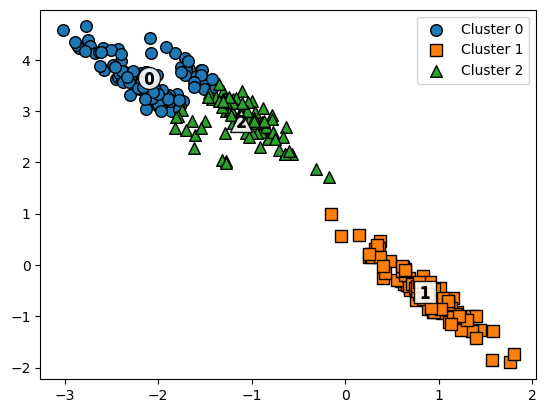

In [15]:
# KMeans가 위 데이터 세트를 어떻게 군집화하는지 확인
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans=KMeans(3,random_state=0)
kmeans_label=kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

- KMeans로 군집화를 수행할 경우, 주로 원형 영역 위치로 개별 군집화가 되면서 원하는 방향으로 구성되지 않음을 알 수 있음
- 이번에는 GMM으로 군집화를 수행해보자

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


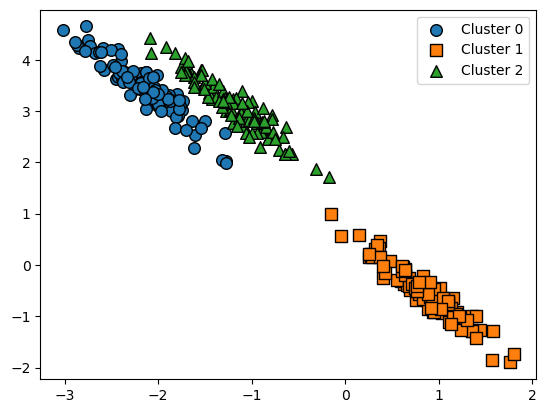

In [16]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용 
gmm=GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter=False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

- 데이터가 분포된 방향에 따라 정확하게 군집화되었음을 알 수 있음
- GMM은 K-평균과 다르게 군집의 중심 좌표를 구할 수 없기 때문에 군집 중심 표현이 visualize_cluster_plot()에서 시각화되지 않음

In [17]:
# make_blobs()의 target값과 KMeans, GMM의 군집 Label값을 비교해 위와 같은 데이터 세트에서 얼만큼의 군집화 효율 차이가 발생하는지 확인
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


- KMeans: 군집 1번만 정확히 매핑되었고, 나머지 군집은 target값과 어긋나는 경우가 발생
- GMM: 군집이 target값과 잘 매핑됨

- 이렇게 GMM은 KMeans보다 유연하게 다양한 데이터 세트에 적용될 수 있다는 장점이 있지만 군집화 수행 시간이 오래걸림